In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from Utils.DataLoader import DataLoader
from Utils.DataTransformer import DataTransformer
from Utils.DuckDb.DuckDb import DuckDb
from Utils.DatasetProcessor.DatasetProcessorUtils import DatasetProcessorUtils
from Utils.DataAnalysis import DataAnalysis
from datetime import datetime
import pandas as pd
from typing import List
from Utils import PandasNotebookConfigs
import project_config
import numpy as np
import matplotlib.pyplot as plt
import joblib
from datetime import datetime
from Utils.Datetime import DatetimeUtils
from Utils.Dict import DictUtils
from Utils.Number import NumberUtils

In [3]:
PandasNotebookConfigs.config()

Ajustando display.float.format para %.4f
Ajustando prints de linhas e colunas


In [4]:
# Less than this percentage of certain = Bad Prediction
BAD_PREDICTIONS_THRESHOLD = 0.60

In [5]:
DUCK_DB = DuckDb()
DATA_TRANSFORMER = DataTransformer()
DATA_PROCESSOR_UTILS = DatasetProcessorUtils(DUCK_DB)
DATETIME_UTILS = DatetimeUtils()
DICT_UTILS = DictUtils()
DATA_ANALYSIS = DataAnalysis()
NUMBER_UTILS = NumberUtils()

In [6]:
df = DUCK_DB.load_table(
    project_config.PREDICTED_DATA_TABLE
)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [7]:
len(df)

1251070

In [8]:
# Get only churn labeled data to check why our model isn't predicting well
df = df[df['no_churn_information'] == False]

In [9]:
len(df)

660119

In [10]:
df.head()[['is_churn', 'predicted_is_churn', 'predicted_is_churn_proba_false', 'predicted_is_churn_proba_true']]

,is_churn,predicted_is_churn,predicted_is_churn_proba_false,predicted_is_churn_proba_true
0,True,False,0.6110,0.3890
1,False,False,0.9461,0.0539
5,False,False,0.7199,0.2801
6,False,False,0.7881,0.2119
7,True,True,0.3547,0.6453


In [11]:
def create_is_bad_prediction_column(df: pd.DataFrame) -> pd.DataFrame:
    def process(row: pd.Series):
        biggest_proba = max(
            row['predicted_is_churn_proba_false'],
            row['predicted_is_churn_proba_true']
        )
        return biggest_proba < BAD_PREDICTIONS_THRESHOLD
    
    df['is_bad_prediction'] = df.apply(lambda row: process(row), axis=1)
    return df

df = create_is_bad_prediction_column(df)
df.head()

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,msno_1,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,safra_1,transaction_date_year,transaction_date_month,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,membership_expire_date_year,membership_expire_date_month,membership_expire_date_day,membership_expire_date_day_of_week,membership_expire_date_day_of_year,discount,price_per_month,members_msno,members_safra,is_active,registration_init_time_year,registration_init_time_month,registration_init_time_day,registration_init_time_day_of_week,registration_init_time_day_of_year,_filled_out_members_info,is_churn,no_churn_information,num_unq-2M,num_unq-1M,total_secs-2M,total_secs-1M,num_25-2M,num_25-1M,num_50-2M,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M,remaining_days,_filled_out_past_info,payment_method_id_6,payment_method_id_8,payment_method_id_10,payment_method_id_11,payment_method_id_12,payment_method_id_13,payment_method_id_14,payment_method_id_15,payment_method_id_16,payment_method_id_17,payment_method_id_18,payment_method_id_19,payment_method_id_20,payment_method_id_21,payment_method_id_22,payment_method_id_23,payment_method_id_26,payment_method_id_27,payment_method_id_28,payment_method_id_29,payment_method_id_30,payment_method_id_31,payment_method_id_32,payment_method_id_33,payment_method_id_34,payment_method_id_35,payment_method_id_36,payment_method_id_37,payment_method_id_38,payment_method_id_39,payment_method_id_40,payment_method_id_41,city_1,city_10,city_11,city_12,city_13,city_14,city_15,city_16,city_17,city_18,city_19,city_20,city_21,city_22,city_3,city_4,city_5,city_6,city_7,city_8,city_9,registered_via_13,registered_via_3,registered_via_4,registered_via_7,registered_via_9,payment_method_id_0,payment_method_id_1,payment_method_id_2,payment_method_id_3,payment_method_id_4,payment_method_id_5,payment_method_id_7,payment_method_id_9,payment_method_id_24,payment_method_id_25,city_0,city_2,registered_via_0,registered_via_1,registered_via_2,registered_via_5,registered_via_6,registered_via_8,registered_via_10,registered_via_11,registered_via_12,registered_via_14,registered_via_15,registered_via_16,registered_via_17,registered_via_18,registered_via_19,safra_year,safra_month,predicted_is_churn,predicted_is_churn_proba_false,predicted_is_churn_proba_true,is_bad_prediction
0,55.9125,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,60,12,14,7,171,179,49996,13.8878,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,7,0,0,False,False,201609,2016,9,9,4,253,2016,9,14,2,258,0,0.0000,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,True,2004,3,27,5,87,Infos já existentes,True,False,179.0000,179.0000,49996.0000,49996.0000,60.0000,60.0000,12.0000,12.0000,14.0000,14.0000,7.0000,7.0000,171.0000,171.0000,5.0000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2016.0000,9.0000,False,0.6110,0.3890,False
1,67.3556,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,128,71,50,101,470,488,148668,41.2967,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,30,99,99,True,False,201611,2016,11,16,2,321,2016,12,15,3,350,0,99.0000,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,True,2014,6,8,6,159,Infos já existentes,False,False,488.0000,488.0000,148668.0000,148668.0000,128.0000,128.0000,71.0000,71.0000,50.0000,50.0000,101.0000,101.0000,470.0000,470.0000,29.0000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fa

In [12]:
def create_correct_prediction_column(df: pd.DataFrame) -> pd.DataFrame:    
    df['correct_prediction'] = df['is_churn'] == df['predicted_is_churn']
    return df

df = create_correct_prediction_column(df)
df.head(10)[['is_churn', 'predicted_is_churn', 'correct_prediction']]

,is_churn,predicted_is_churn,correct_prediction
0,True,False,False
1,False,False,True
5,False,False,True
6,False,False,True
7,True,True,True
10,False,False,True
11,False,False,True
12,False,False,True
16,False,False,True
17,False,False,True


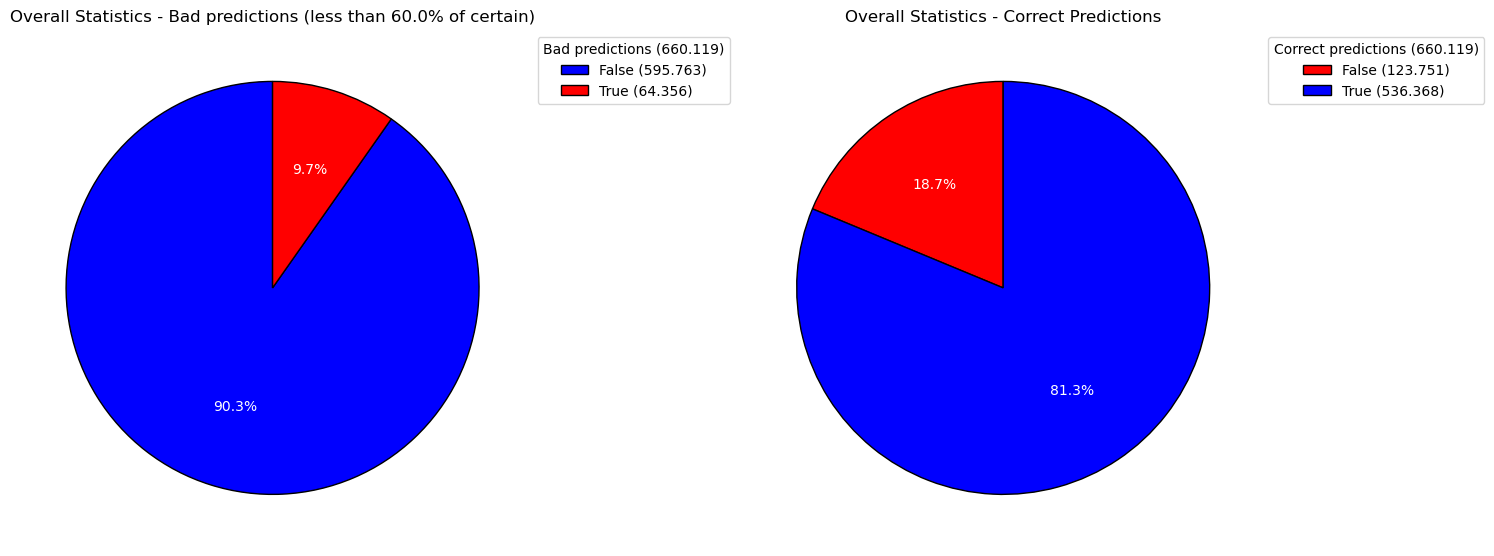

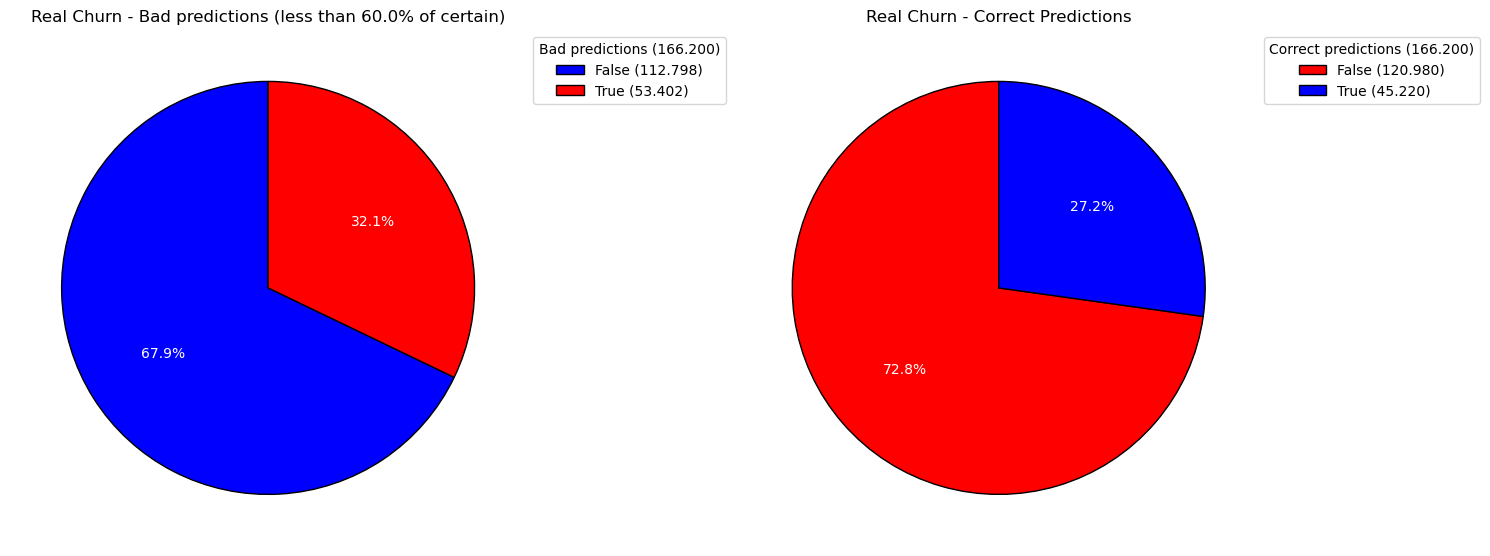

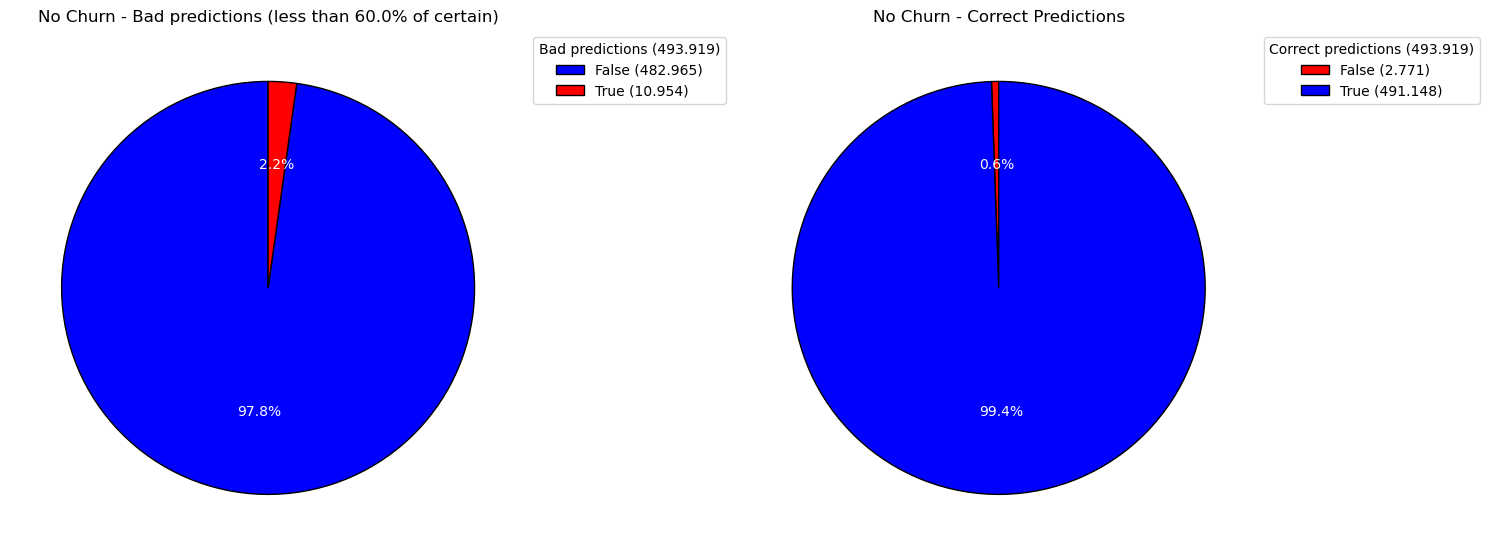

In [13]:
def plot_figures(label: str, df: pd.DataFrame):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 15))
    axes = axes.flatten()

    def generate_labels(counts):
        return [f'{c} ({NUMBER_UTILS.format_integer_number(counts[c])})' for c in counts.index]

    counted = df['is_bad_prediction'].value_counts().sort_index()
    labels = generate_labels(counted)
    DATA_ANALYSIS.plot_pizza(
        value_counts=counted,
        labels=labels,
        title=f'{label} - Bad predictions (less than {BAD_PREDICTIONS_THRESHOLD * 100}% of certain)',
        legend=f'Bad predictions ({NUMBER_UTILS.format_integer_number(counted.sum())})',
        ax=axes[0],
        colors=['blue', 'red'],
        text_color='white'
    )

    counted = df['correct_prediction'].value_counts().sort_index()
    labels = generate_labels(counted)
    DATA_ANALYSIS.plot_pizza(
        value_counts=counted,
        labels=labels,
        title=f'{label} - Correct Predictions',
        legend=f'Correct predictions ({NUMBER_UTILS.format_integer_number(counted.sum())})',
        ax=axes[1],
        colors=['red', 'blue'],
        text_color='white'
    )

    plt.tight_layout()
    plt.show()

plot_figures(
    label='Overall Statistics',
    df=df
)

plot_figures(
    label='Real Churn',
    df=df[df['is_churn'] == True]
)

plot_figures(
    label='No Churn',
    df=df[df['is_churn'] == False]
)

In [14]:
df['predict_certain'] = np.maximum(df['predicted_is_churn_proba_false'], df['predicted_is_churn_proba_true'])

In [15]:
df.head()

,cost,msno,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,msno_1,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,is_cancel,safra_1,transaction_date_year,transaction_date_month,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,membership_expire_date_year,membership_expire_date_month,membership_expire_date_day,membership_expire_date_day_of_week,membership_expire_date_day_of_year,discount,price_per_month,members_msno,members_safra,is_active,registration_init_time_year,registration_init_time_month,registration_init_time_day,registration_init_time_day_of_week,registration_init_time_day_of_year,_filled_out_members_info,is_churn,no_churn_information,num_unq-2M,num_unq-1M,total_secs-2M,total_secs-1M,num_25-2M,num_25-1M,num_50-2M,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M,remaining_days,_filled_out_past_info,payment_method_id_6,payment_method_id_8,payment_method_id_10,payment_method_id_11,payment_method_id_12,payment_method_id_13,payment_method_id_14,payment_method_id_15,payment_method_id_16,payment_method_id_17,payment_method_id_18,payment_method_id_19,payment_method_id_20,payment_method_id_21,payment_method_id_22,payment_method_id_23,payment_method_id_26,payment_method_id_27,payment_method_id_28,payment_method_id_29,payment_method_id_30,payment_method_id_31,payment_method_id_32,payment_method_id_33,payment_method_id_34,payment_method_id_35,payment_method_id_36,payment_method_id_37,payment_method_id_38,payment_method_id_39,payment_method_id_40,payment_method_id_41,city_1,city_10,city_11,city_12,city_13,city_14,city_15,city_16,city_17,city_18,city_19,city_20,city_21,city_22,city_3,city_4,city_5,city_6,city_7,city_8,city_9,registered_via_13,registered_via_3,registered_via_4,registered_via_7,registered_via_9,payment_method_id_0,payment_method_id_1,payment_method_id_2,payment_method_id_3,payment_method_id_4,payment_method_id_5,payment_method_id_7,payment_method_id_9,payment_method_id_24,payment_method_id_25,city_0,city_2,registered_via_0,registered_via_1,registered_via_2,registered_via_5,registered_via_6,registered_via_8,registered_via_10,registered_via_11,registered_via_12,registered_via_14,registered_via_15,registered_via_16,registered_via_17,registered_via_18,registered_via_19,safra_year,safra_month,predicted_is_churn,predicted_is_churn_proba_false,predicted_is_churn_proba_true,is_bad_prediction,correct_prediction,predict_certain
0,55.9125,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,60,12,14,7,171,179,49996,13.8878,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,7,0,0,False,False,201609,2016,9,9,4,253,2016,9,14,2,258,0,0.0000,+++FOrTS7ab3tIgIh8eWwX4FqRv8w/FoiOuyXsFvphY=,201609,True,2004,3,27,5,87,Infos já existentes,True,False,179.0000,179.0000,49996.0000,49996.0000,60.0000,60.0000,12.0000,12.0000,14.0000,14.0000,7.0000,7.0000,171.0000,171.0000,5.0000,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2016.0000,9.0000,False,0.6110,0.3890,False,False,0.6110
1,67.3556,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,128,71,50,101,470,488,148668,41.2967,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,30,99,99,True,False,201611,2016,11,16,2,321,2016,12,15,3,350,0,99.0000,+++hVY1rZox/33YtvDgmKA2Frg/2qhkz12B9ylCvh8o=,201611,True,2014,6,8,6,159,Infos já existentes,False,False,488.0000,488.0000,148668.0000,148668.0000,128.0000,128.0000,71.0000,71.0000,50.0000,50.0000,101.0000,101.0000,470.0000,470.0000,29.0000,True,False,False,False,False,False,False,False,False,False,False,False,Fa

In [16]:
good_predictions = df[df['is_bad_prediction'] == False]
poor_predictions = df[df['is_bad_prediction'] == True]

In [17]:
len(good_predictions), len(poor_predictions)

(595763, 64356)

In [18]:
poor_predictions['is_churn'].value_counts()

is_churn
True     53402
False    10954
Name: count, dtype: int64

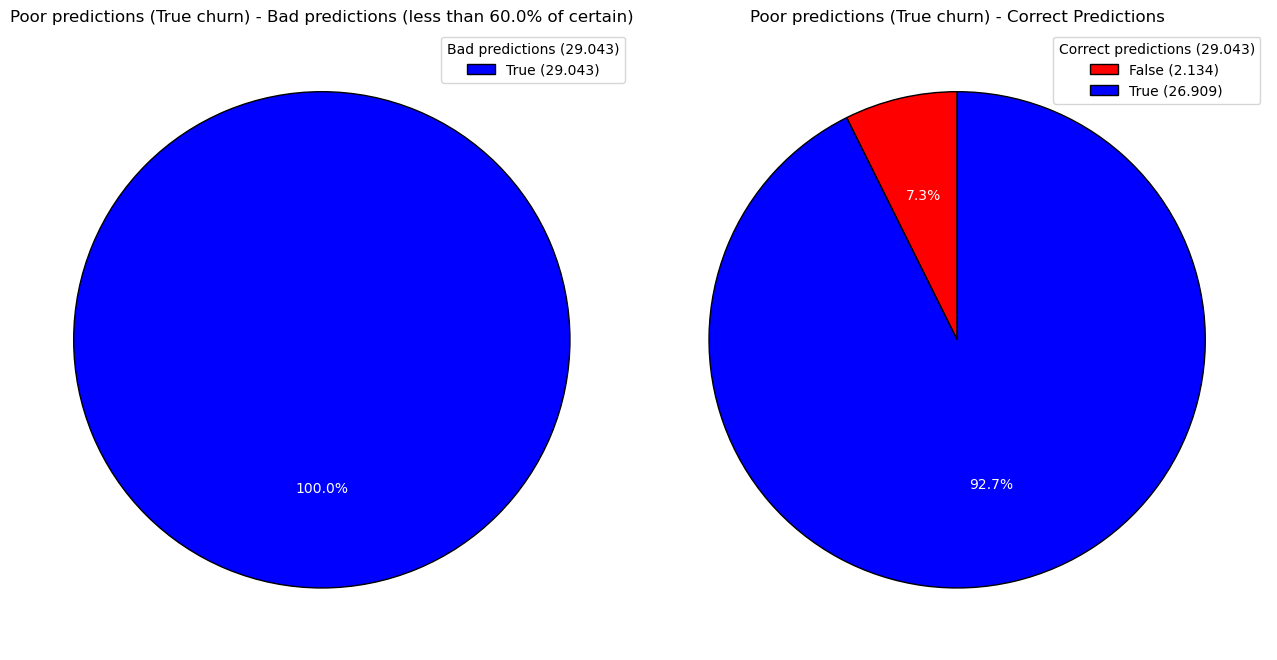

In [19]:
plot_figures(
    label='Poor predictions (True churn)',
    df=poor_predictions[(poor_predictions['predicted_is_churn'] == True)]
)

# plot_figures(
#     label='Poor predictions (False churn)',
#     df=poor_predictions[(poor_predictions['predicted_is_churn'] == False)]
# )

In [20]:
poor_predictions[poor_predictions['predicted_is_churn'] == False].value_counts()

cost      msno                                          safra   num_25  num_50  num_75  num_985  num_100  num_unq  total_secs  total_hours  msno_1                                        payment_plan_days  plan_list_price  actual_amount_paid  is_auto_renew  is_cancel  safra_1  transaction_date_year  transaction_date_month  transaction_date_day  transaction_date_day_of_week  transaction_date_day_of_year  membership_expire_date_year  membership_expire_date_month  membership_expire_date_day  membership_expire_date_day_of_week  membership_expire_date_day_of_year  discount  price_per_month  members_msno                                  members_safra  is_active  registration_init_time_year  registration_init_time_month  registration_init_time_day  registration_init_time_day_of_week  registration_init_time_day_of_year  _filled_out_members_info  is_churn  no_churn_information  num_unq-2M  num_unq-1M  total_secs-2M  total_secs-1M  num_25-2M  num_25-1M  num_50-2M  num_50-1M  num_75-2M  num_75-1M 

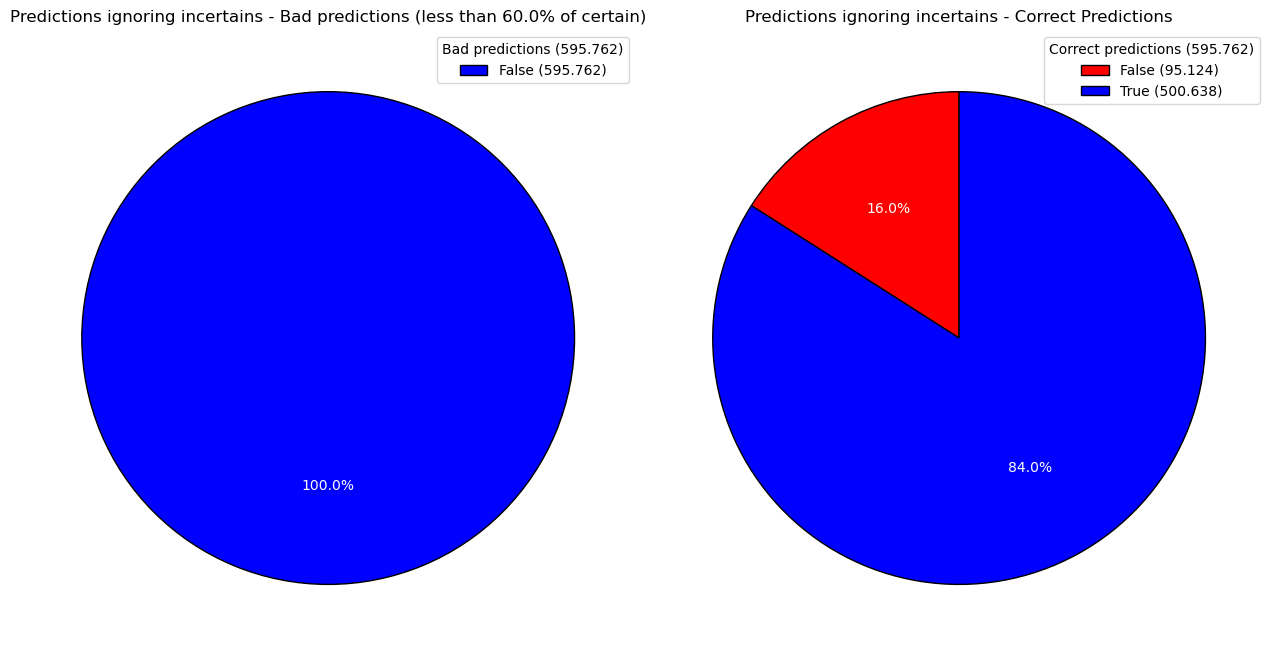

In [21]:
plot_figures(
    label='Predictions ignoring incertains',
    df=df[(df['predict_certain'] > BAD_PREDICTIONS_THRESHOLD)]
)

In [22]:
poor_predictions[(poor_predictions['predicted_is_churn'] == True)]['is_churn'].value_counts()

is_churn
True     26909
False     2134
Name: count, dtype: int64

In [23]:
poor_predictions[(poor_predictions['predicted_is_churn'] == False)]['is_churn'].value_counts()

is_churn
True     26493
False     8820
Name: count, dtype: int64

In [24]:
poor_predictions['predicted_is_churn'].value_counts()

predicted_is_churn
False    35313
True     29043
Name: count, dtype: int64

In [25]:
poor_predictions['is_churn'].value_counts()

is_churn
True     53402
False    10954
Name: count, dtype: int64

In [26]:
len(good_predictions), len(poor_predictions)

(595763, 64356)

In [27]:
good_predictions.describe()

,cost,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,payment_plan_days,plan_list_price,actual_amount_paid,safra_1,transaction_date_year,transaction_date_month,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,membership_expire_date_year,membership_expire_date_month,membership_expire_date_day,membership_expire_date_day_of_week,membership_expire_date_day_of_year,discount,price_per_month,members_safra,num_unq-2M,num_unq-1M,total_secs-2M,total_secs-1M,num_25-2M,num_25-1M,num_50-2M,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M,remaining_days,safra_year,safra_month,predicted_is_churn_proba_false,predicted_is_churn_proba_true,predict_certain
count,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000,595763.0000
mean,64.1050,201609.9862,111.4876,27.0815,17.1222,18.6147,437.9454,461.1786,117529.6383,32.6471,30.6212,136.4015,136.0798,201609.9862,2016.0000,9.9862,17.3666,2.8263,291.2774,2016.0327,10.7051,16.1261,2.9469,311.8140,0.3217,132.7491,201609.9862,454.6502,461.4753,116083.6305,117548.8585,108.9960,111.6784,27.2144,27.4766,17.0884,17.3123,18.5460,18.8195,431.4590,437.0663,32.5127,2016.0000,9.9862,0.8298,0.1702,0.8401
std,14.1446,0.8133,164.7845,34.9748,20.6437,27.4614,466.4772,454.7394,120258.7167,33.4052,10.8635,49.4224,49.8061,0.8133,0.0000,0.8133,9.7221,1.9872,26.4118,0.1779,1.9061,9.2760,2.0180,59.0097,6.7959,30.3469,0.8133,450.8735,452.9973,120159.3090,119842.3164,159.2265,164.0291,35.0196,35.3003,20.4454,20.7251,26.8951,27.1723,465.6390,463.9830,12.8399,0.0000,0.8133,0.1335,0.1335,0.1043
min,50.0052,201609.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0003,1.0000,0.0000,0.0000,201609.0000,2016.0000,9.0000,1.0000,0.0000,245.0000,2016.0000,1.0000,1.0000,0.0000,1.0000,0.0000,0.0000,201609.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2016.0000,9.0000,0.0256,0.0103,0.6000
25%,53.7069,201609.0000,20.0000,5.0000,4.0000,4.0000,105.0000,126.0000,30019.0000,8.3386,30.0000,99.0000,99.0000,201609.0000,2016.0000,9.0000,9.0000,1.0000,270.0000,2016.0000,10.0000,8.0000,1.0000,297.0000,0.0000,99.0000,201609.0000,125.0000,128.0000,29380.0000,30373.5000,20.0000,20.0000,6.0000,6.0000,4.0000,4.0000,4.0000,4.0000,101.0000,105.0000,30.0000,2016.0000,9.0000,0.7597,0.0712,0.7611
50%,59.6772,201610.0000,57.0000,15.0000,10.0000,11.0000,287.0000,323.0000,79315.0000,22.0319,30.0000,149.0000,149.0000,201610.0000,2016.0000,10.0000,17.0000,3.0000,291.0000,2016.0000,11.0000,16.0000,3.0000,321.0000,0.0000,149.0000,201610.0000,316.0000,324.0000,77372.0000,79364.0000,57.0000,58.0000,16.0000,16.0000,10.0000,11.0000,11.0000,11.0000,278.0000,286.0000,30.0000,2016.0000,10.0000,0.8749,0.1251,0.8753
75%,69.7168,201611.0000,137.0000,35.0000,23.0000,24.0000,604.0000,650.0000,163278.5000,45.3551,30.0000,149.0000,149.0000,201611.0000,2016.0000,11.0000,26.0000,4.0000,313.0000,2016.0000,12.0000,24.0000,5.0000,342.0000,0.0000,149.0000,201611.0000,638.0000,650.0000,160378.5000,163220.5000,135.0000,138.0000,35.0000,35.0000,23.0000,23.0000,24.0000,24.0000,591.0000,602.0000,31.0000,2016.0000,11.0000,0.9288,0.2403,0.9288
max,135.0943,201611.0000,5574.0000,394.0000,214.0000,1870.0000,6005.0000,4320.0000,655188.0000,181.9967,410.0000,1000.0000,1000.0000,201611.0000,2016.0000,11.0000,31.0000,6.0000,335.0000,2017.0000,12.0000,31.0000,6.0000,366.0000,149.0000,180.0000,201611.0000,4320.0000,4320.0000,655188.0000,655188.0000,4747.0000,4814

In [28]:
poor_predictions.describe()

,cost,safra,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,total_hours,payment_plan_days,plan_list_price,actual_amount_paid,safra_1,transaction_date_year,transaction_date_month,transaction_date_day,transaction_date_day_of_week,transaction_date_day_of_year,membership_expire_date_year,membership_expire_date_month,membership_expire_date_day,membership_expire_date_day_of_week,membership_expire_date_day_of_year,discount,price_per_month,members_safra,num_unq-2M,num_unq-1M,total_secs-2M,total_secs-1M,num_25-2M,num_25-1M,num_50-2M,num_50-1M,num_75-2M,num_75-1M,num_985-2M,num_985-1M,num_100-2M,num_100-1M,remaining_days,safra_year,safra_month,predicted_is_churn_proba_false,predicted_is_churn_proba_true,predict_certain
count,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000,64356.0000
mean,56.2703,201610.3401,46.7949,11.4838,6.7552,7.3796,198.6165,198.4887,52579.7687,14.6055,20.5367,80.6027,80.3604,201610.3401,2016.0000,10.3401,18.8431,3.0529,303.5748,2016.1698,9.1339,15.4358,3.0931,263.3597,0.2422,72.3468,201610.3401,205.3293,211.8238,54342.7548,56153.0382,48.1464,49.8362,12.0705,12.3162,7.1281,7.3261,7.8417,8.1048,204.4492,211.4073,21.9823,2016.0000,10.3401,0.5079,0.4921,0.5505
std,13.0850,0.7753,126.1283,27.9659,15.5649,20.5811,439.8752,406.1094,111532.1817,30.9812,19.0575,95.9928,96.0015,0.7753,0.0000,0.7753,9.7981,1.9449,26.7266,0.3755,3.6993,9.5942,2.0353,113.6350,5.9006,73.9535,0.7753,403.4998,418.5740,111133.7978,114987.7063,124.7372,129.8595,28.4709,28.8984,15.9334,16.4160,21.2507,22.6962,436.4125,451.0916,23.0981,0.0000,0.7753,0.0577,0.0577,0.0291
min,50.0052,201609.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0003,1.0000,0.0000,0.0000,201609.0000,2016.0000,9.0000,1.0000,0.0000,245.0000,2016.0000,1.0000,1.0000,0.0000,1.0000,0.0000,0.0000,201609.0000,1.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2016.0000,9.0000,0.4000,0.4000,0.5000
25%,50.1629,201610.0000,2.0000,0.0000,0.0000,0.0000,3.0000,8.0000,1152.7500,0.3202,7.0000,0.0000,0.0000,201610.0000,2016.0000,10.0000,10.0000,2.0000,291.0000,2016.0000,9.0000,6.0000,1.0000,265.0000,0.0000,0.0000,201610.0000,8.0000,8.0000,1285.0000,1291.0000,3.0000,3.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,3.0000,3.0000,7.0000,2016.0000,10.0000,0.4595,0.4408,0.5253
50%,50.9934,201611.0000,10.0000,3.0000,2.0000,1.0000,25.0000,37.0000,7818.0000,2.1717,30.0000,99.0000,99.0000,201611.0000,2016.0000,11.0000,21.0000,3.0000,308.0000,2016.0000,11.0000,15.0000,3.0000,310.0000,0.0000,99.0000,201611.0000,41.0000,40.0000,8656.5000,8603.5000,11.0000,11.0000,3.0000,3.0000,2.0000,2.0000,2.0000,2.0000,28.0000,28.0000,7.0000,2016.0000,11.0000,0.5098,0.4902,0.5505
75%,55.1082,201611.0000,38.0000,10.0000,6.0000,6.0000,152.2500,171.0000,41996.7500,11.6658,30.0000,149.0000,149.0000,201611.0000,2016.0000,11.0000,28.0000,5.0000,326.0000,2016.0000,11.0000,25.0000,5.0000,328.0000,0.0000,149.0000,201611.0000,196.0000,193.0000,48410.2500,48018.2500,41.0000,42.0000,11.0000,11.0000,7.0000,7.0000,7.0000,7.0000,175.0000,174.0000,31.0000,2016.0000,11.0000,0.5592,0.5405,0.5759
max,132.4096,201611.0000,5073.0000,394.0000,213.0000,1063.0000,7505.0000,4275.0000,655085.0000,181.9681,410.0000,894.0000,894.0000,201611.0000,2016.0000,11.0000,31.0000,6.0000,335.0000,2017.0000,12.0000,31.0000,6.0000,366.0000,149.0000,180.0000,201611.0000,4275.0000,4275.0000,655085.0000,655175.0000,5073.0000,5073.0000,394.0000,394.0000,214.0000,213.0000,1063.0000,1671.0000,5566.0000,6005.0000,199.0000,2016.0000,11.0000,0.6000,0.